In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
from textwrap import wrap

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

## Load model weights and data

In [3]:
sys.path.append('../models/cWGAN/Run_2021-02-23_1/')
import cWGAN
save_dir = '../models/cWGAN/Run_2021-02-23_1/'
assert(os.path.isdir(save_dir))

In [4]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCut.txt", skiprows=2)

In [5]:
normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

normalized_data = (normalized_data - normalized_mean) / normalized_std

In [6]:
cwgan = cWGAN.cWGAN(0.01, 10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [7]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_450000')

## Make Predictions

In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [9]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 8s, sys: 3.26 s, total: 1min 11s
Wall time: 2.49 s


In [10]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
predict[:, 3] = 10**predict[:, 3]

## Make Joint Distribution Plot

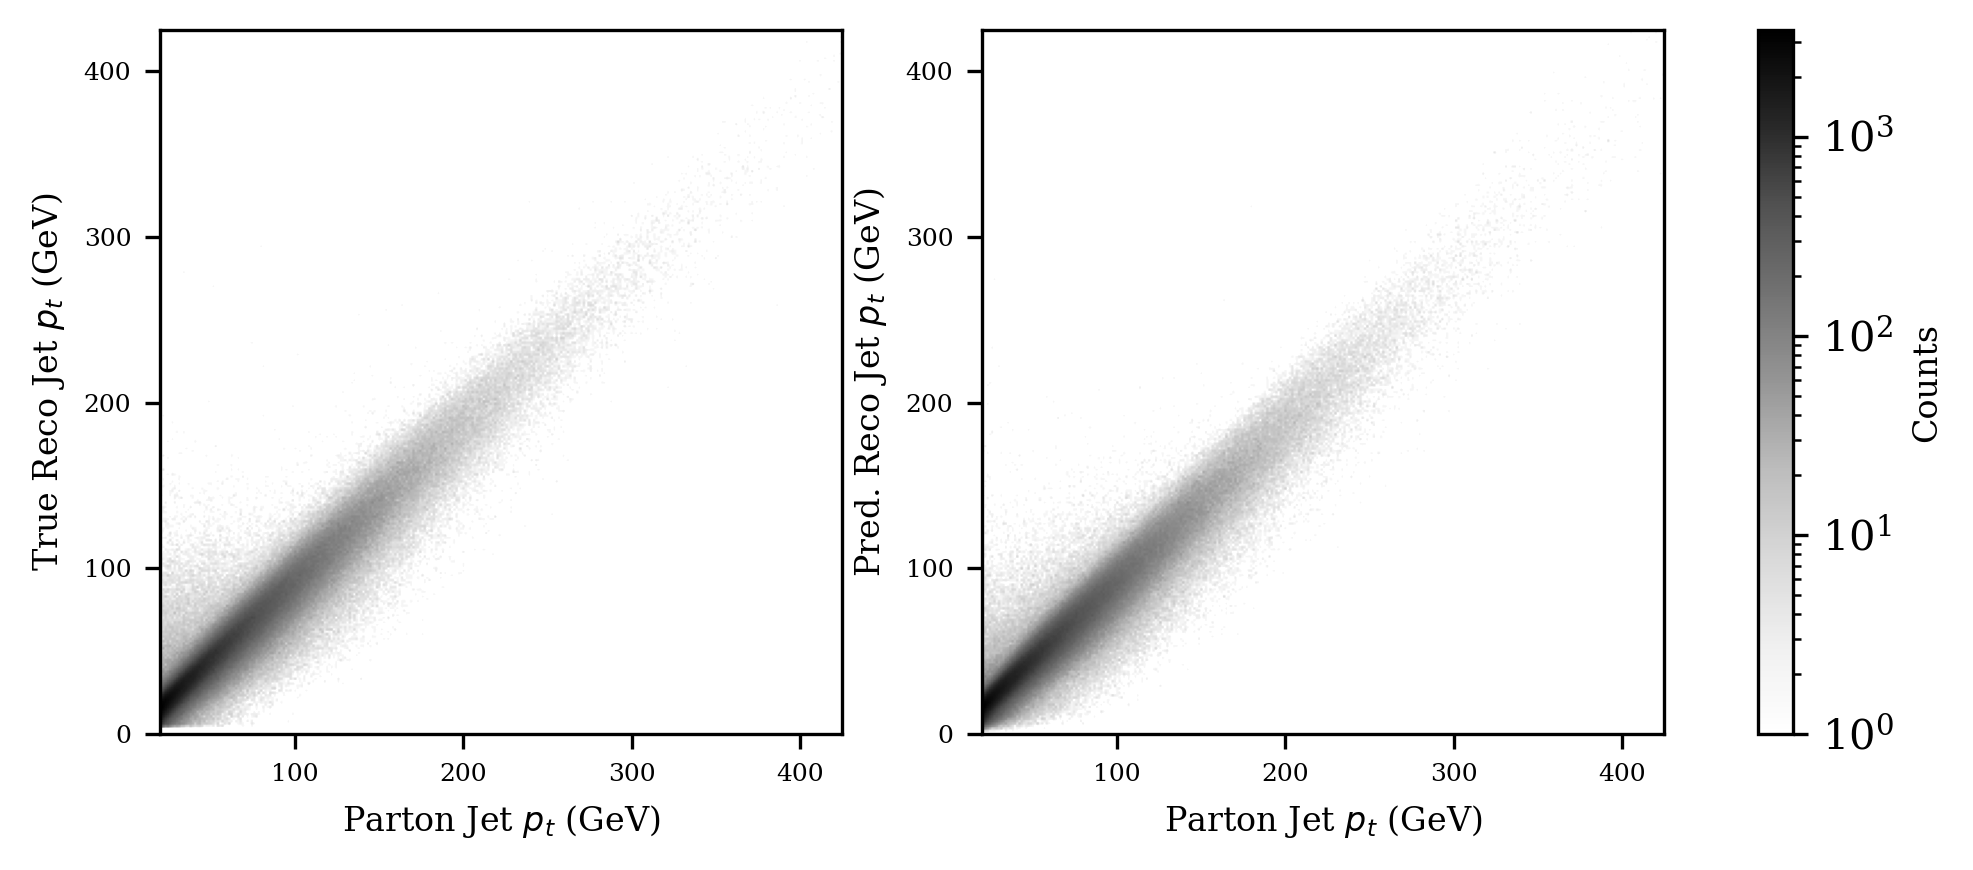

In [34]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
fig = plt.figure(figsize=(7,3), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 425
y_low = 0
y_hi = 425
num_bins=300
ytickvals = [0, 100, 200, 300, 400]
xtickvals = [100, 200, 300, 400]

h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"Parton Jet $p_t$ (GeV)", size=8)
ax1.set_ylabel(r"True Reco Jet $p_t$ (GeV)", size=8)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.set_yticks(ytickvals)
ax1.set_xticks(xtickvals)

#ax1.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and True Reco Jet $P_t$", width=40)), size=8)


z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
hist = ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Parton Jet $p_t$ (GeV)", size=8)
ax2.set_ylabel(r"Pred. Reco Jet $p_t$ (GeV)", size=8)
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_yticks(ytickvals)
ax2.set_xticks(xtickvals)
#ax2.set_yticks([0, 100, 200, 300, 400])
#ax2.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and Predicted Reco Jet $P_t$", width=40)), size=10)

#plt.xticks(fontsize=6)
#plt.yticks(fontsize=6)

plt.tight_layout()
cb = plt.colorbar(hist, ax=[ax1, ax2])
cb.set_label(label="Counts", size=8)
plt.savefig('../data/plots/jointdistribution.png')
plt.show()

<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_diff = diff / h2
<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = diff / h2


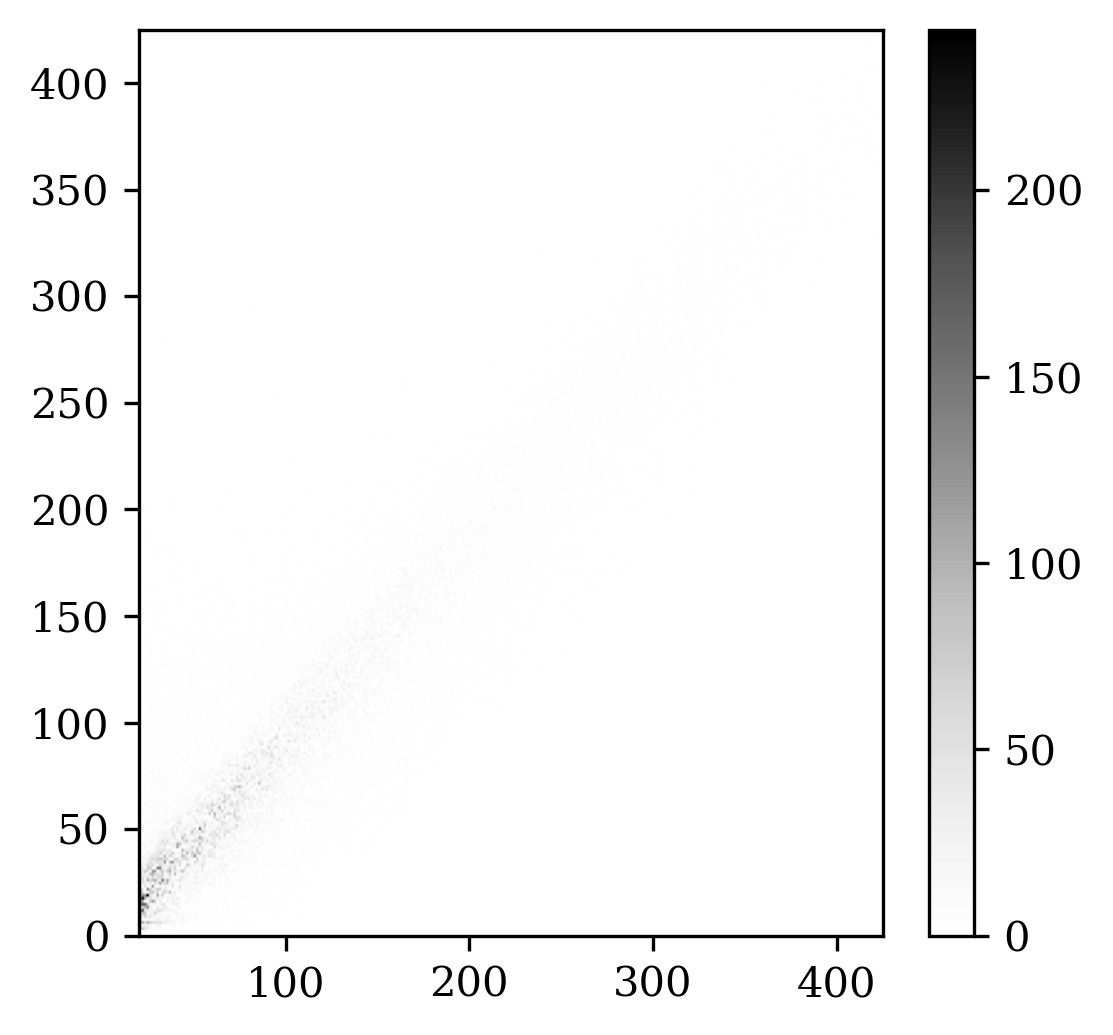

In [28]:
diff = np.abs(h2-z2)
rel_diff = diff / h2
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.add_subplot(111)
hist = ax.imshow(diff.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys")#, norm=mcolors.LogNorm())
plt.colorbar(hist)
plt.show()


## Make Marginal Distribution Plots

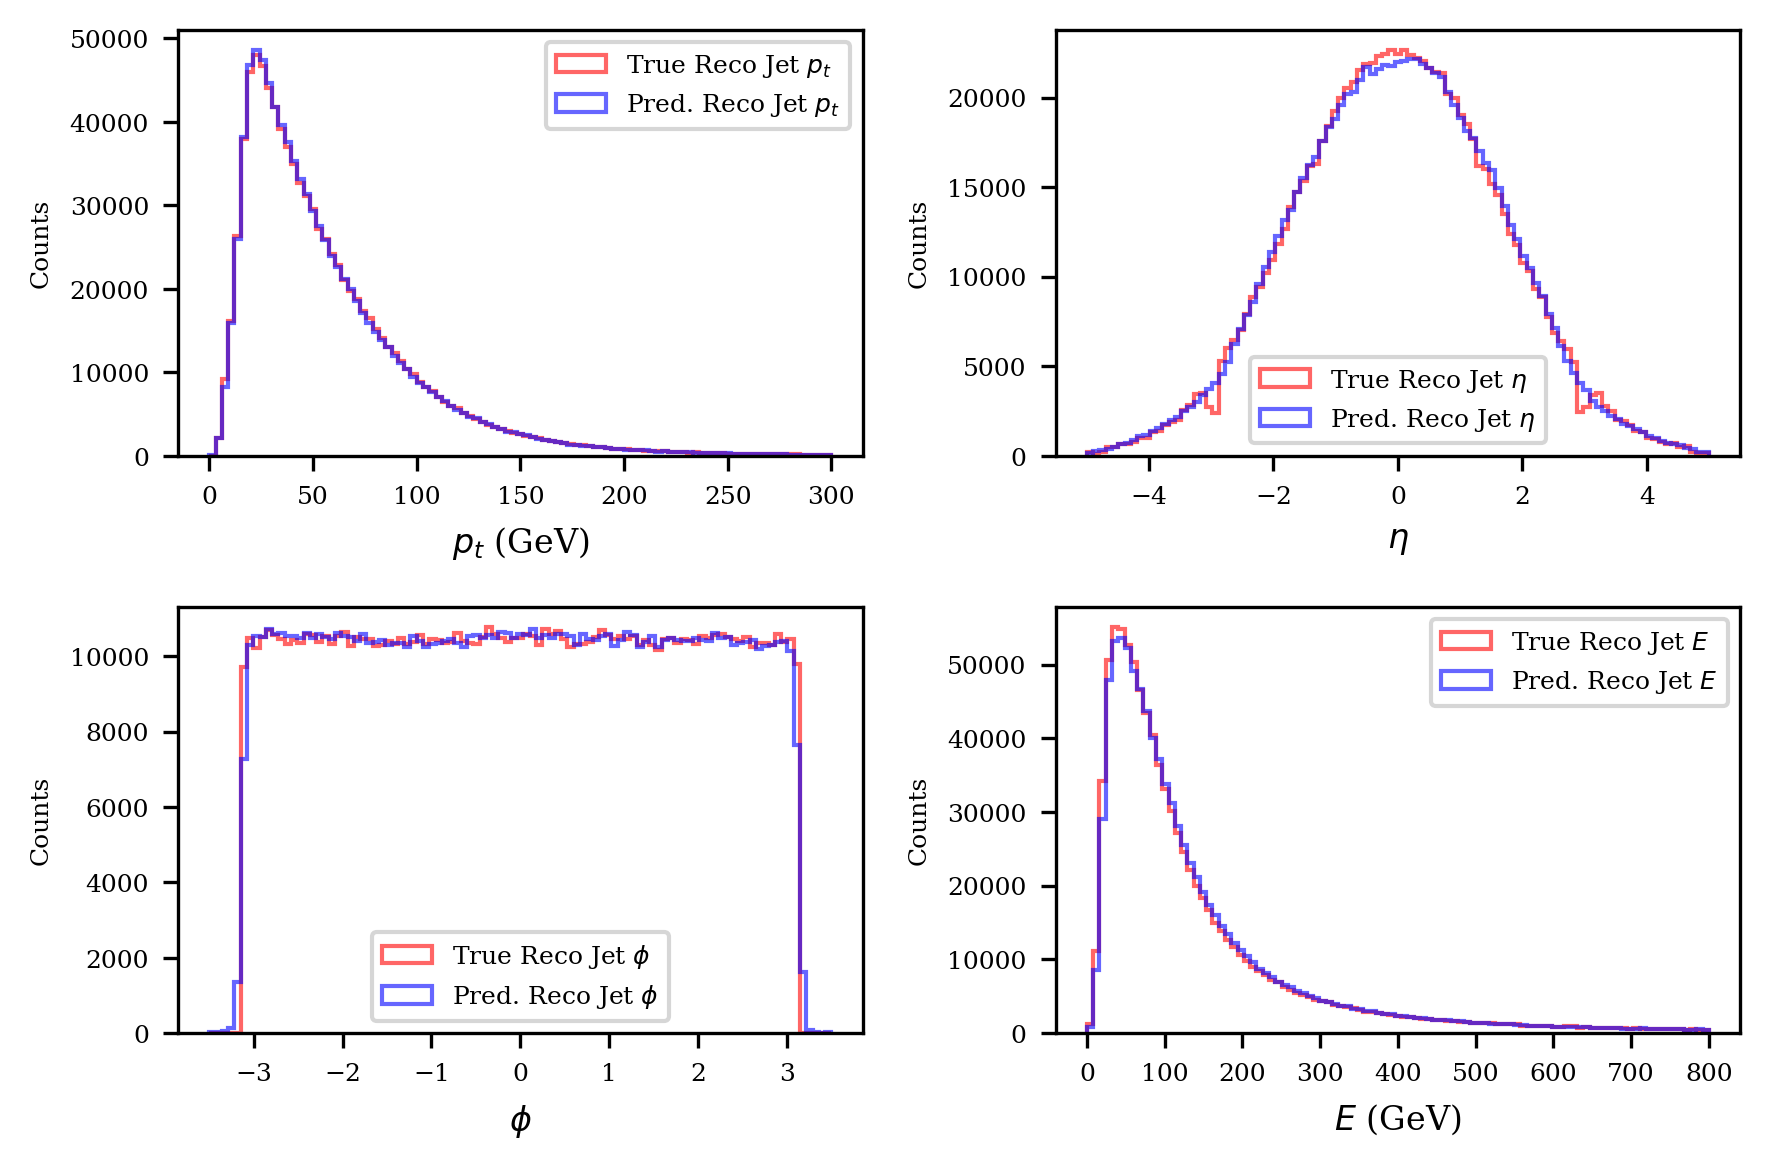

In [37]:
fig = plt.figure(figsize=(6,4), dpi=300)
bins = np.linspace(0, 300, 100)
ax1 = fig.add_subplot(221)
ax1.hist(data[:, 4], label=r"True Reco Jet $p_t$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax1.hist(predict[:, 0], label=r"Pred. Reco Jet $p_t$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax1.set_title(r"True and Predicted Marginal Reco Jet $P_t$ Distributions")
ax1.set_xlabel(r"$p_t$ (GeV)", size=8)
ax1.set_ylabel("Counts", size=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.legend(fontsize=6)

bins = np.linspace(-5, 5, 100)
ax2 = fig.add_subplot(222)
ax2.hist(data[:, 5], label=r"True Reco Jet $\eta$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax2.hist(predict[:, 1], label=r"Pred. Reco Jet $\eta$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax2.set_title(r"True and Predicted Marginal Reco Jet $\eta$ Distributions")
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_xlabel(r"$\eta$", size=8)
ax2.set_ylabel("Counts", size=6)
ax2.legend(loc='lower center', fontsize=6)

bins = np.linspace(-3.5, 3.5, 100)
ax3 = fig.add_subplot(223)
ax3.hist(data[:, 6], label=r"True Reco Jet $\phi$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax3.hist(predict[:, 2], label=r"Pred. Reco Jet $\phi$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax3.set_title(r"True and Predicted Marginal Jet $\phi$ Distributions")
ax3.tick_params(axis='x', labelsize=6)
ax3.tick_params(axis='y', labelsize=6)
ax3.set_xlabel(r"$\phi$", size=8)
ax3.set_ylabel("Counts", size=6)
ax3.legend(loc='lower center', fontsize=6)

bins = np.linspace(0, 800, 100)
ax4 = fig.add_subplot(224)
ax4.hist(data[:, 7], label=r"True Reco Jet $E$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax4.hist(predict[:, 3], label=r"Pred. Reco Jet $E$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax4.set_title(r"True and Predicted Marginal Reco Jet Energy Distributions")
ax4.set_xlabel(r"$E$ (GeV)", size=8)
ax4.set_ylabel("Counts", size=6)
ax4.tick_params(axis='x', labelsize=6)
ax4.tick_params(axis='y', labelsize=6)
ax4.legend(fontsize=6)
plt.tight_layout()

#plt.show()
plt.savefig("../data/plots/marginalDists.pdf")

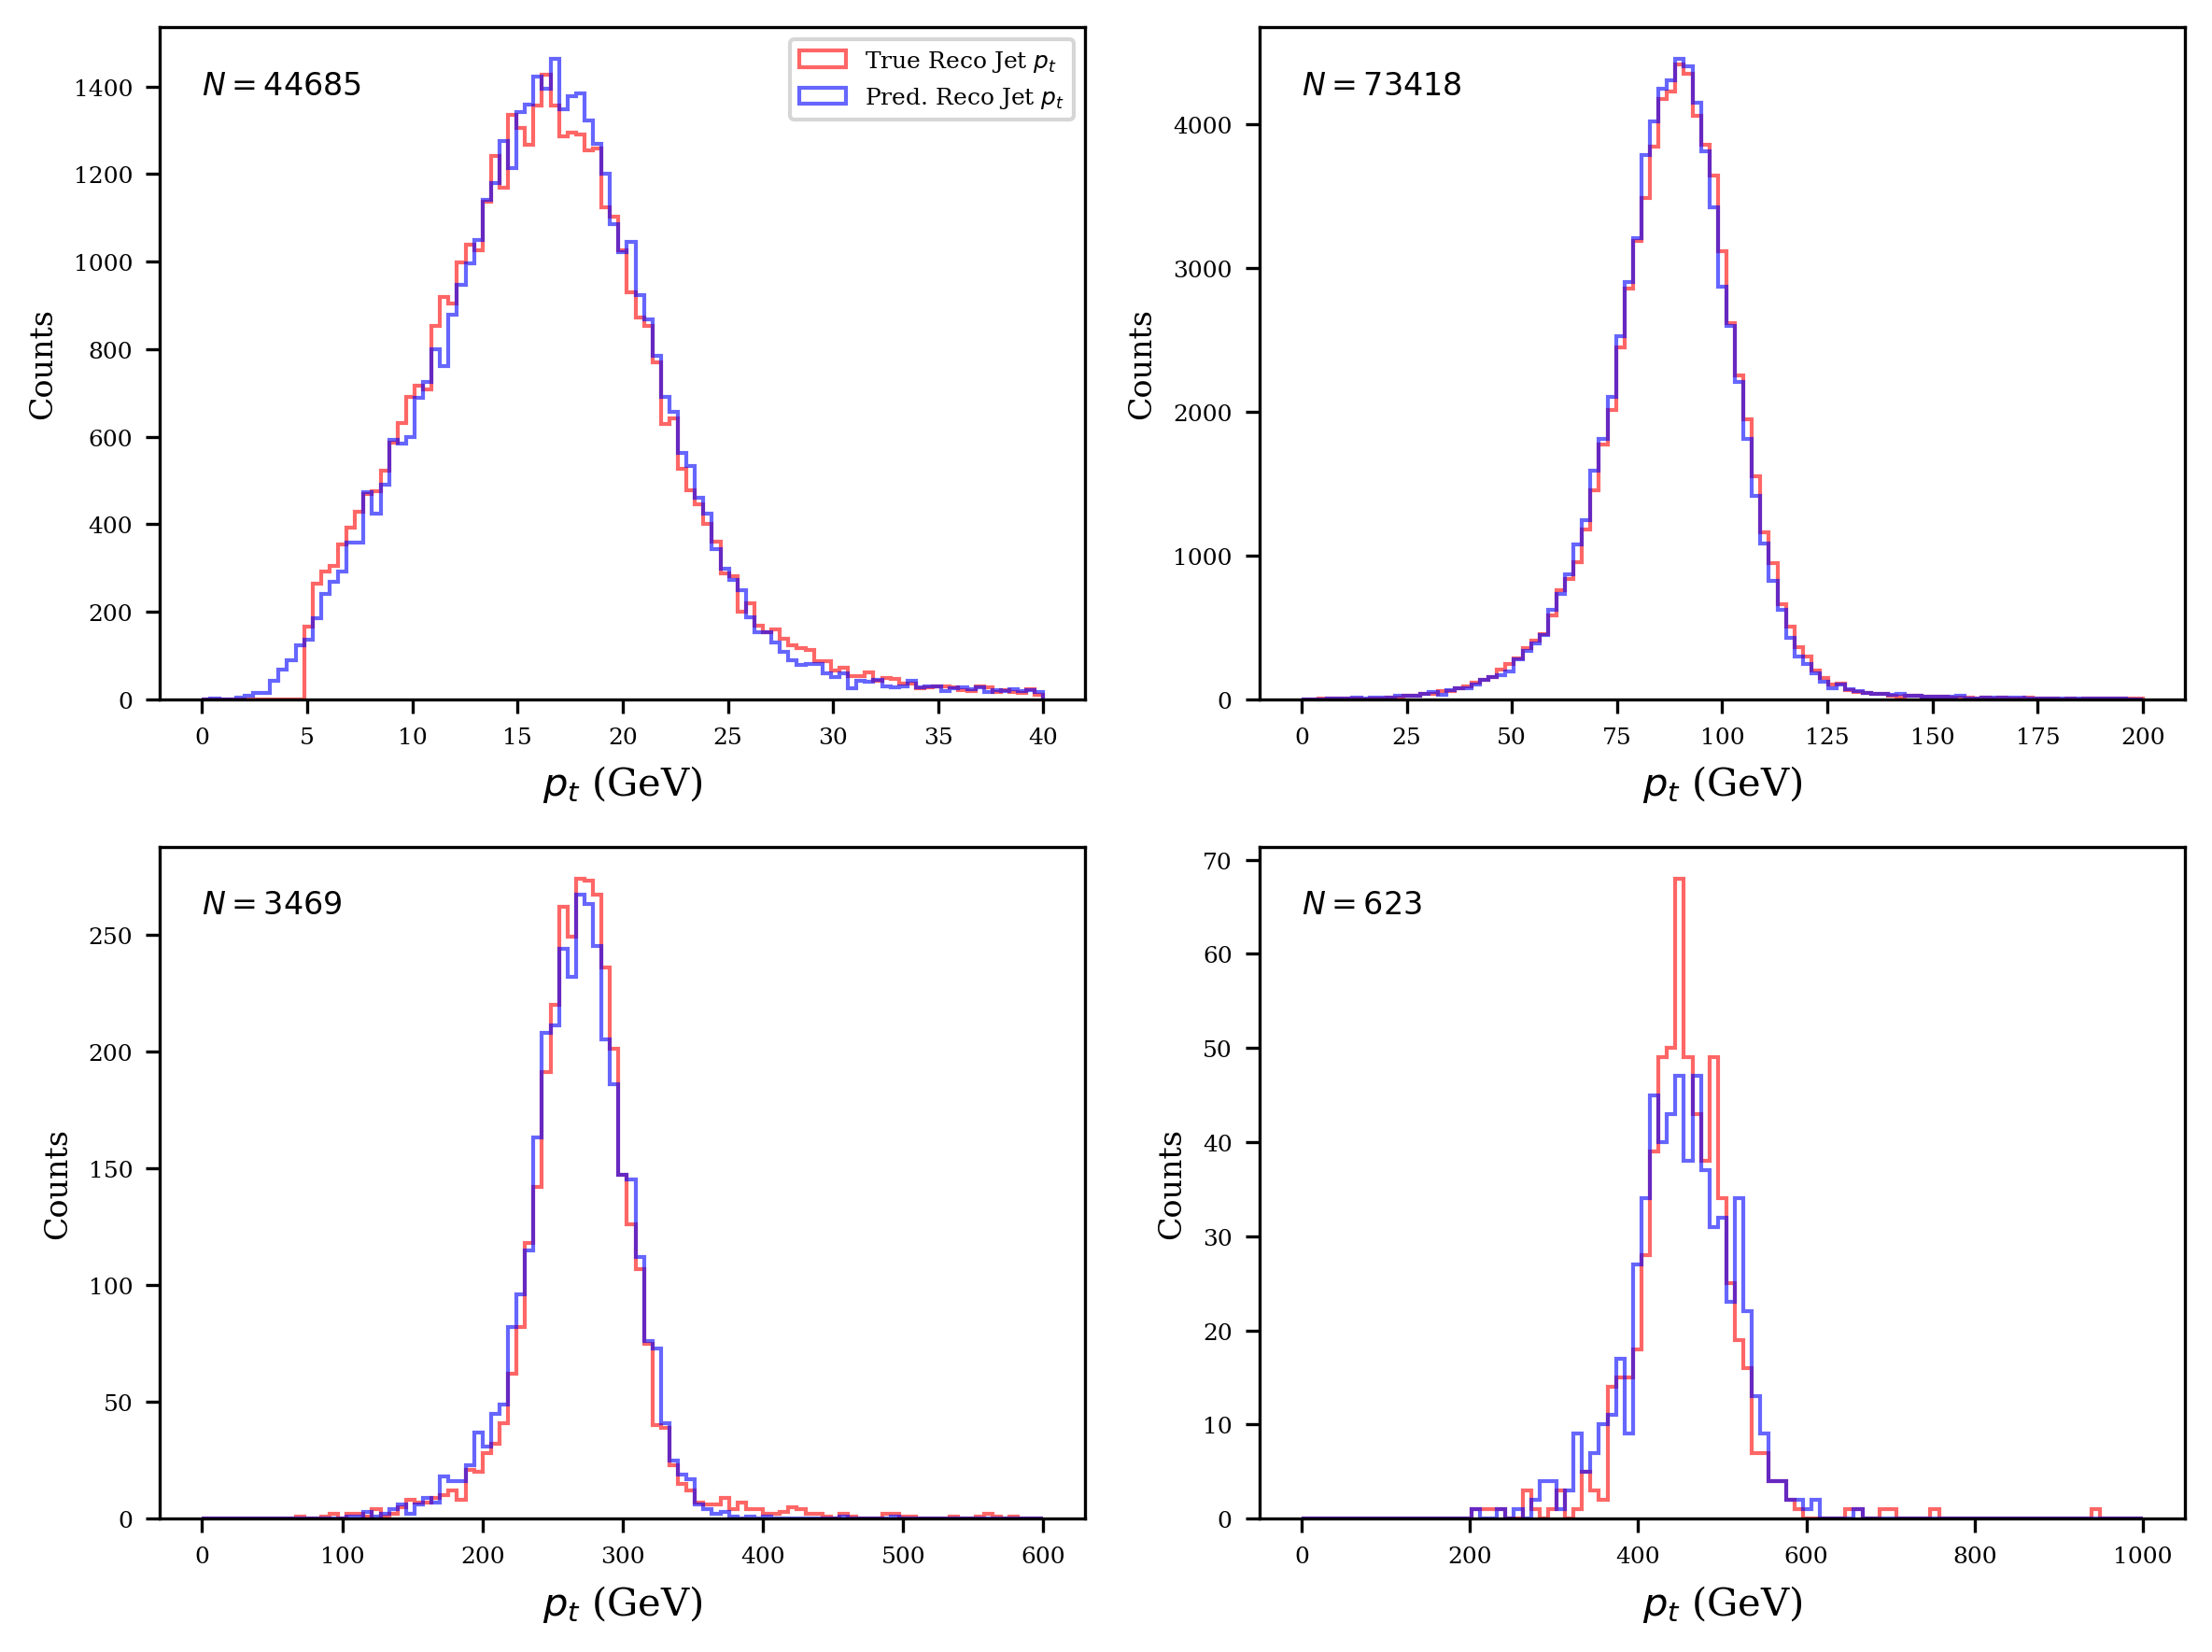

In [40]:
plt.rc('font', family='serif')
range_highs = [40, 200, 600, 1000]
range_lows = [0, 0, 0, 0, 0]
j = 0
nrow = 2; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8,6), dpi=300)
ax = axs.flatten()

for center in [20, 100, 300, 500]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    #fig = plt.figure(figsize=(6,4), dpi=100)
    #ax = fig.add_subplot(111)
    ax[j].hist(recoPt, bins=bins, label=r'True Reco Jet $p_t$', alpha=0.6, ec="r", histtype='step')
    ax[j].hist(predPt, bins=bins, label=r'Pred. Reco Jet $p_t$', alpha=0.6, ec="b", histtype='step')
    ax[j].text(0,0.9*ax[j].get_ylim()[1], r"$N={}$".format(len(recoPt)), size=8)
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    #if j==2 or j==3:
    ax[j].set_xlabel(r"$p_t$ (GeV)")
    ax[j].set_ylabel("Counts", size=8)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    #ax[j].set_ylabel("Count")
    #ax[j].set_title("Parton Jet $P_t =${} GeV".format(center), size=10)
    #ax[j].set_title("\n".join(wrap(r"True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [{}, {}]$ GeV".format(low, high), width=50)), fontsize=8)
    #ax.axvline(x=center/2)
    if j ==0:
        ax[j].legend(fontsize=6)
    #fig.savefig("../data/plots/PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1
#fig.suptitle(r"Conditional Reco $P_t$ Distributions")
plt.tight_layout()
plt.savefig("../data/plots/ConditionalPtDistPres.pdf")
plt.show()



In [22]:
print(data[6, :])
print(normalized_data[6, :])

[1.03079e+02 3.80138e-02 9.90804e-01 1.05946e+02 9.80344e+01 3.91551e-02
 1.04147e+00 1.00190e+02]
[ 1.05327631  0.02640799  0.5468874  -0.12164268]


In [23]:
same_point = np.zeros((500000, 4))

In [24]:
for i in range(len(same_point)):
    same_point[i, :] = normalized_data[6, :]

In [25]:
repeat_predict = np.array(cwgan.make_generator_predictions(same_point))
repeat_predict = repeat_predict * reco_std + reco_mean
repeat_predict[:, 0] = 10**repeat_predict[:, 0]
repeat_predict[:, 3] = 10**repeat_predict[:, 3]

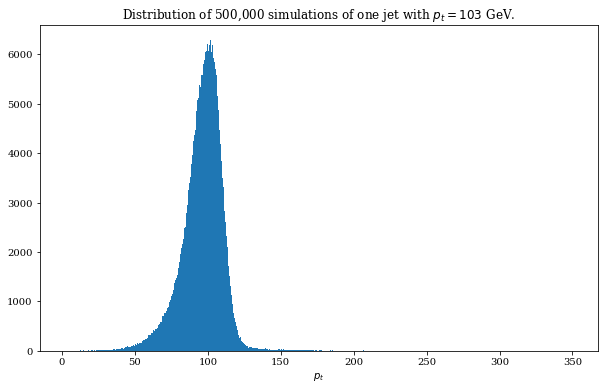

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 0], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $p_t = 103$ GeV.")
ax.set_xlabel(r"$p_t$")
plt.show()

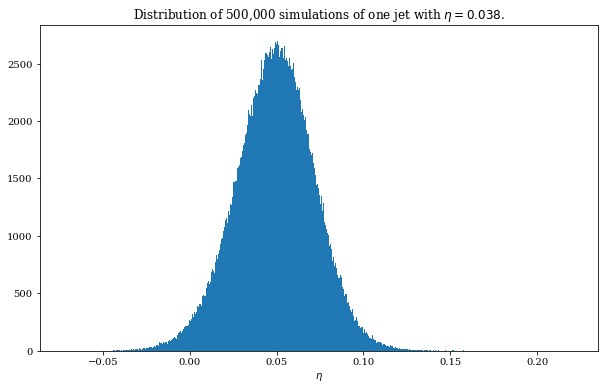

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 1], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\eta = 0.038$.")
ax.set_xlabel(r"$\eta$")
plt.show()

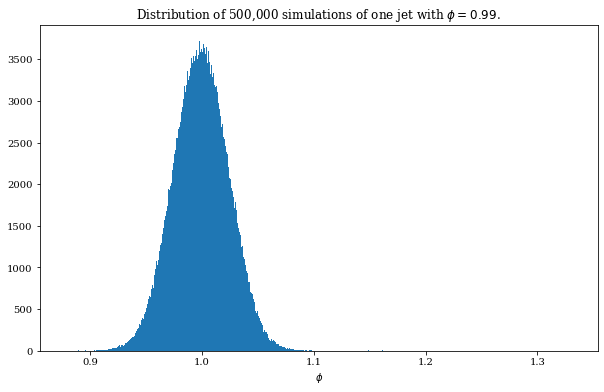

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 2], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\phi = 0.99$.")
ax.set_xlabel(r"$\phi$")
plt.show()

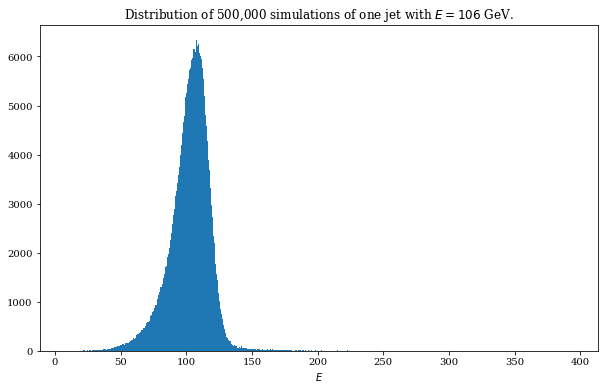

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 3], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $E = 106$ GeV.")
ax.set_xlabel(r"$E$")
plt.show()